In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from itertools import product
import numpy as np

In [2]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=6, out_features=2, bias=True)
        self.layer2 = nn.Linear(in_features=2, out_features=1, bias=True)
    def forward(self, x):
        out = torch.sigmoid(self.layer1(x))
        out = torch.sigmoid(self.layer2(out))
        return out
net=NN()

In [3]:
for p in net.parameters():
    torch.nn.init.uniform_(p, a=-0.3, b=0.3)
    print(p)

Parameter containing:
tensor([[-0.0941, -0.2158, -0.2683, -0.0149,  0.1967,  0.1074],
        [-0.0850,  0.1333, -0.1353, -0.2628,  0.2354,  0.1115]],
       requires_grad=True)
Parameter containing:
tensor([-0.2357,  0.2450], requires_grad=True)
Parameter containing:
tensor([[-0.0687,  0.0967]], requires_grad=True)
Parameter containing:
tensor([0.0592], requires_grad=True)


In [4]:
def mirrored(seq):
    if seq[0]==seq[-1] and seq[1]==seq[-2] and seq[2]==seq[-3]:
        return 1.0
    else:
        return 0.0

In [5]:
x = [i for i in product(range(2), repeat=6)]
x=torch.tensor(x, dtype=torch.float32)
y=torch.zeros(len(x))
for i in range(len(x)):
    y[i]=mirrored(x[i])
y=y.reshape(64,1)
print(x)
print(y)

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1., 1.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1., 1.],
        [0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 1.],
        [0., 1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 1., 1.],
        [0., 1., 1., 1., 0., 0.],
        [0., 1

In [6]:
train = data_utils.TensorDataset(x, y)
train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=False)

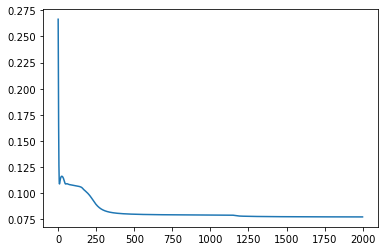

In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss = torch.nn.MSELoss()
losses=[]
for epoch in range(2000):
    for i, data in enumerate(train_loader):
        seq=data[0]
        label=data[1]
        y=net(seq)
        l=loss(y, label)
        losses.append(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
from matplotlib import pyplot as plt
plt.plot(losses)

In [8]:
net(x), label

(tensor([[9.7064e-01],
         [1.1529e-04],
         [1.7609e-01],
         [1.3089e-02],
         [1.7702e-01],
         [1.7602e-01],
         [1.7602e-01],
         [1.7602e-01],
         [2.1415e-02],
         [6.1671e-03],
         [3.2552e-03],
         [1.1457e-04],
         [9.7070e-01],
         [1.1531e-04],
         [1.7609e-01],
         [1.3634e-02],
         [5.5552e-03],
         [1.1456e-04],
         [1.7558e-01],
         [1.1652e-04],
         [1.7602e-01],
         [1.7602e-01],
         [1.7602e-01],
         [1.7602e-01],
         [5.9479e-03],
         [1.1457e-04],
         [1.1457e-04],
         [1.1456e-04],
         [5.8059e-03],
         [1.1456e-04],
         [1.7559e-01],
         [1.1657e-04],
         [1.7608e-01],
         [1.7530e-01],
         [1.7602e-01],
         [1.7602e-01],
         [1.7602e-01],
         [1.7602e-01],
         [1.7602e-01],
         [1.7602e-01],
         [2.7320e-03],
         [1.1457e-04],
         [1.6143e-02],
         [1

In [9]:
for p in net.parameters():
    print(p)

Parameter containing:
tensor([[ 12.6696,  11.9730,  -9.8652,   9.8553,  12.5224,  11.9354],
        [-14.5471,   6.6283,  28.3334, -28.3570,  -7.7536,  13.9098]],
       requires_grad=True)
Parameter containing:
tensor([-3.2231, -6.6924], requires_grad=True)
Parameter containing:
tensor([[-5.2523, -7.5307]], requires_grad=True)
Parameter containing:
tensor([3.7088], requires_grad=True)
